# Detecção de Pornografia em Imagens

Importar todas as bibliotecas necessárias

In [1]:
from os import listdir
import cv2
import math
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import  validation_curve
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from sklearn.externals import joblib
from scipy import ndimage
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

Uso de um detector de faces (VIOLA;JONES,2004)

In [2]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

Classe interna que representa uma região de pele

In [3]:
class SkinRegion(object):

    def __init__(self, image, skin_mask, label_number,rectangle_slices):
               
        self.label_number = label_number
        self.y0 = rectangle_slices[0].start
        self.y1 = rectangle_slices[0].stop
        self.x0 = rectangle_slices[1].start 
        self.x1 = rectangle_slices[1].stop

        self.bounding_rectangle_size = (self.x1-self.x0)*(self.y1-self.y0)
        self.bounding_rectangle_skin_pixels = np.count_nonzero(skin_mask[rectangle_slices])
        self.bounding_rectangle_average_pixel_intensity = np.average(image[rectangle_slices].take([0], axis=2))

Função que reconhece pixeis de pele por meio de um classificador explícito nos espaços de cores RGB e YCbCr baseado nas seguintes regras (MEDINA; PALLADINO, 2013):

RGB (KOVAC et al., 2005)

(R > 95 & G > 40 & B > 20 & max(R,G,B) - min(R,G,B) > 15 
& |R – G| > 15 & R > G & R > B)

YCbCr (BASILIO et al., 2011)

80 < Cb < 120 & 133 < Cr < 173

In [4]:
def get_skin_mask(image, image_in_ycrcb):

    return np.logical_and(

        np.logical_and(
            np.logical_and(
                (np.abs(image.take([2], axis=2) - image.take([1], axis=2)) > 15).\
                    squeeze(),
                (image.take([2], axis=2) > image.take([1], axis=2)).squeeze()
            ),
            np.logical_and(
                np.logical_and(
                    np.all(
                        image > [20, 40, 95],
                        axis=2
                    ),
                    (np.amax(image, axis=2) - np.min(image, axis=2)) > 15
                ),
                (image.take([2], axis=2) > image.take([0], axis=2)).squeeze()
            )
        ),

        np.all(
            np.logical_and(
                [0, 133, 80] <= image_in_ycrcb,
                image_in_ycrcb <= [255, 173, 120]
            ),
            axis=2
        )
    )

Função que retorna as 3 maiores regiões de pixeis de pele, assim como o polígono que abrange essas regiões

In [5]:
def get_skin_regions(imageYCrCb, skin_mask):
    regions = []

    labeled_image, regions_count = ndimage.label(skin_mask)
    region_rectangles_slices = ndimage.find_objects(labeled_image) #So this object is found at x = 19–23 and y = 0–2
    
    for i in range(regions_count):
        label = i + 1
        region = SkinRegion(imageYCrCb, skin_mask, label, region_rectangles_slices[i])
        regions.append(region)
    #Pega as 3 maiores regioes
    num_regions = 3    
    if (len(regions) < 3):
    	num_regions = len(regions)
    regions = sorted(regions, key=lambda r: r.bounding_rectangle_skin_pixels, reverse=True)[0:num_regions]
    #gerar o poligono contendo as 3 maiores regioes
    #alterar pra 1 tudo q for dos 3 poligonos e 0 o resto 
    for i in range(0, num_regions):
    	labeled_image[labeled_image == regions[i].label_number] = -1
    labeled_image[labeled_image >= 0] = 0
    labeled_image[labeled_image == -1] = 1
    if (num_regions != 0):
        region_rectangles_slices_b = ndimage.find_objects(labeled_image)
        region_poligono = SkinRegion(imageYCrCb, skin_mask, 1, region_rectangles_slices_b[0])
        regions.append(region_poligono)
    return regions, regions_count

Função que extrai as características da imagem

In [6]:
def get_features(regions, imageBGR, imageYCrCb, mask, num_regions):
	# Create figure and axes
	features = np.zeros(17)
	for i in range(0,len(regions)):
		features[i*3] = regions[i].bounding_rectangle_size #pixels total
		features[i*3 + 1] = regions[i].bounding_rectangle_skin_pixels #pixels pele
		features[i*3 + 2] = regions[i].bounding_rectangle_average_pixel_intensity #media intensidade
	features[12] = imageYCrCb.shape[0] * imageYCrCb.shape[1] #pixels total
	features[13] = np.count_nonzero(mask) #pixels pele
	features[14] = np.average(imageYCrCb.take([0], axis=2)) #media intensidade
	faces = face_cascade.detectMultiScale(imageYCrCb.take([0], axis=2), 1.3, 5)
	features[15] = len(faces) # numero de faces
	for (x,y,w,h) in faces:
	    features[16] += w*h
	return features

Função que abre o arquivo de imagem e chama a função que extrai as características da imagem

In [7]:
def get_features_from_image(file):
	imageBGR = cv2.imread(file)
	imageRGB = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2RGB)
	imageYCrCb = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2YCR_CB)
	mask = get_skin_mask(imageBGR, imageYCrCb)	
	regions, num_regions = get_skin_regions(imageYCrCb, mask)
	features = get_features(regions, imageBGR, imageYCrCb, mask, num_regions)
	return features

Função que prediz a imagem individualmente

In [8]:
def predict_image(file, clf):
	imageBGR = cv2.imread(file)
	imageRGB = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2RGB)
	imageYCrCb = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2YCR_CB)
	mask = get_skin_mask(imageBGR, imageYCrCb)	
	regions, num_regions = get_skin_regions(imageYCrCb, mask)
	features = get_features(regions, imageBGR, imageYCrCb, mask, num_regions)
	faces = face_cascade.detectMultiScale(imageYCrCb.take([0], axis=2), 1.3, 5)
	fig = plt.figure()
	ax1 = fig.add_subplot(2,2,1)
	ax1.set_title("Target Image")
	ax1.imshow(imageRGB)
	ax1.axis('off')
	ax2 = fig.add_subplot(2,2,2)
	ax2.set_title("Skin Regions")
	ax2.imshow(mask, cmap='Greys', interpolation='nearest')
	ax2.axis('off')
	ax3 = fig.add_subplot(2,2,3)
	ax3.set_title("Faces Detected")
	ax3.imshow(imageRGB)
	ax3.axis('off')
	result = cv2.cvtColor(cv2.imread("result.jpg"), cv2.COLOR_BGR2RGB)
	ax4 = fig.add_subplot(2,2,4)
	ax4.set_title("Result")
	ax4.imshow(result)
	result_text = "Not Nude!" if clf.predict(features.reshape(1, -1)) == [0] else "   Nude!" 
	ax4.text(result.shape[0]/2*1.28, result.shape[1]/2, result_text, fontsize=10)
	ax4.axis('off')
	color = 'r'
	for i in range(len(regions)-1,-1,-1):
		if (i != len(regions)-1):
			color = 'g'
		rect = patches.Rectangle((regions[i].x0,regions[i].y0),regions[i].x1 - regions[i].x0,regions[i].y1 - regions[i].y0,linewidth=2,edgecolor=color,facecolor='none')
		#Add the patch to the Axes
		ax2.add_patch(rect)
	color = 'b'
	for (x,y,w,h) in faces:
	    rect = patches.Rectangle((x,y),w,h,linewidth=2,edgecolor=color,facecolor='none')
	    ax3.add_patch(rect)
	plt.show()

Função que cria um arquivo com as características de cada imagem e seu respectivo rótulo

In [9]:
def create_features_file(nude_path, not_nude_path, file_name):
	file = open(file_name, 'w')
	files_nude = listdir(nude_path)
	files_not_nude = listdir(not_nude_path)

	for i in range(0,len(files_nude)):
		print("{}) {}".format(i, files_nude[i]))
		features = get_features_from_image(nude_path+files_nude[i])
		file.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(features[0],features[1],features[2],features[3],features[4],features[5],features[6],features[7],features[8],features[9],features[10],features[11],features[12],features[13],features[14],features[15],features[16],1))

	for i in range(0,len(files_not_nude)):
		print("{}) {}".format(i, files_not_nude[i]))
		features = get_features_from_image(not_nude_path+files_not_nude[i])
		file.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(features[0],features[1],features[2],features[3],features[4],features[5],features[6],features[7],features[8],features[9],features[10],features[11],features[12],features[13],features[14],features[15],features[16],0))
	file.close()

Função que lê o arquivo com as características de cada imagem e seu respectivo rótulo

In [10]:
def read_features_data(file):
	headr = ["F1","F2","F3","F4","F5","F6","F7","F8","F9","F10","F11","F12","F13","F14","F15","F16","F17","Y"]
	data = pd.read_csv(file, delimiter='\t', header=None)
	data.columns = headr
	#shuffle
	np.random.seed(1234)
	data = data.iloc[np.random.permutation(len(data))]
	X = data.loc[:,'F1':'F17']
	Y = data.loc[:,'Y']
	return[X,Y]

Função que imprime a acurácia do treino de da validação de acordo com a variação do parametro do modelo escolhido

In [11]:
def print_acc(train,validation,param, range, name):
    result = np.concatenate((train[:,np.newaxis], validation[:,np.newaxis]), axis=1)
    result = pd.DataFrame(result, index=range, columns=['Train','Validation'])
    print("{0} - {1} versus ACCURACY \n {2} \n".format(name, param, result))

Função que plota o gráfico da acurácia do treino de da validação de acordo com a variação do parametro do modelo escolhido

In [12]:
def plot_acc(train,validation,param, range, name):
	plt.xlabel(param)
	plt.ylabel('ACCURACY')
	plt.title(name)
	line1, = plt.plot(range, train, label="Train")
	line2, = plt.plot(range, validation, label="Validation")
	first_legend = plt.legend(handles=[line1], loc=1)
	ax = plt.gca().add_artist(first_legend)
	plt.legend(handles=[line2], loc=4)
	plt.show()

Função que calcula a acurácia do treino de da validação de acordo com a variação do parametro do modelo escolhido

In [13]:
def calc_acc(model,param,range,name, X_train, Y_train):
    [train,validation] = validation_curve(model, X_train, Y_train, scoring="accuracy", param_name=param, param_range=range, cv = 5)
    train = train.mean(axis=1)
    validation = validation.mean(axis=1)
    print_acc(train,validation,param, range, name)
    plot_acc(train,validation,param, range, name)

Extrai as características de todos os 12.740 arquivos (nudez e não-nudez)

(Procedimento muito demorado e não vai funcionar, pois a base de dados é muito grande e não foi "upada", mas o arquivo com as características já foi criado e está disponível)

In [14]:
#create_features_file("database\\AIIA\\nude\\","database\\AIIA\\not_nude\\","nude_not_nude.txt")

Leitura do arquivo que contém as características de cada imagem e seu respectivo rótulo

In [15]:
X,Y = read_features_data("nude_not_nude.txt")

Reserva de 10% dos arquivos para o teste e os demais para treino e validação

In [16]:
X_matrix = X.values
Y_matrix = Y.values
X_train = X_matrix[0:11466,:]
Y_train = Y_matrix[0:11466]
X_test = X_matrix[11466:,:]
Y_test = Y_matrix[11466:]

Classificador: Rede Neural

Validação cruzada com objetivo de tunar os hiperparametros:

* camadas: 4, 5, 6
* unidades escondidas: 100, 200, 300, 400
* fator de regularização (primeira etapa): 0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000
* fator de regularização (segunda etapa): 40, 60, 80, 100, 120, 140, 160

(Procedimento muito demorado. Não é necessário executar)

In [17]:
#alpha = [0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000]
#camadas = []
#for k in range(100,500,100):
#	for i in range(4,7):
#		for j in range(i):
#			camadas.append(k)
#		clf = MLPClassifier(max_iter=1000, shuffle=False, hidden_layer_sizes=camadas)
#		clf = calc_acc(clf,"alpha",alpha,"MLP",X_train,Y_train)
#		camadas = []	

#clf = MLPClassifier(max_iter=1000, shuffle=False, hidden_layer_sizes=camadas)
#alpha = [40, 60, 80, 100, 120, 140, 160]
#clf = calc_acc(clf,"alpha",alpha,"MLP",X_train,Y_train)

Encontrados os melhores hiperparametros para a validação cruzada, treina-se o modelo:

* camadas: 5
* unidades escondidas: 300
* fator de regularização: 60

(Procedimento um pouco demorado. O modelo treinado foi disponibilizado)

In [18]:
#clf = MLPClassifier(alpha=70, max_iter=1000, hidden_layer_sizes=camadas,  shuffle=False)
#clf.fit(X_train,Y_train)
#joblib.dump(clf, 'MLP_L5_HU300_A60.pkl') 
clf = joblib.load('MLP_L5_HU300_A60.pkl')

Realiza-se a predição com os "arquivos" reservados para o teste, retornando sua respectiva acurácia:

In [19]:
print(clf.score(X_test, Y_test))

0.894034536892


Classificador: Árvore de Decisão

Validação cruzada com objetivo de tunar o hiperparametro:

* Mínimo de unidades para dividir: 2, 4, 8, 16, 32, 64, 128, 256

(Procedimento pouco demorado. Não é necessário executar)

In [20]:
#clf = DecisionTreeClassifier()
#min_samples_split = [2, 4, 8, 16, 32, 64, 128, 256]
#calc_acc(clf,"min_samples_split",min_samples_split,"Decision Tree",X_train,Y_train)

Encontrados o melhore hiperparametro para a validação cruzada, treina-se o modelo:

* Mínimo de unidades para dividir: 32

(Procedimento um pouco demorado. O modelo treinado foi disponibilizado)

In [21]:
#clf = DecisionTreeClassifier(min_samples_split=32)
#clf.fit(X_train,Y_train)
#joblib.dump(clf, 'DECTREE_MIN32.pkl') 
clf = joblib.load('DECTREE_MIN32.pkl')

Realiza-se a predição com os "arquivos" reservados para o teste, retornando sua respectiva acurácia:

In [22]:
print(clf.score(X_test, Y_test))

0.923861852433


Classificador: Árvores Aleatórias

Validação cruzada com objetivo de tunar o hiperparametro:

* Mínimo de unidades para dividir: 2, 4, 8, 16, 32, 64, 128, 256

(Procedimento pouco demorado. Não é necessário executar)

In [23]:
#clf = RandomForestClassifier()
#min_samples_split = [2, 4, 8, 16, 32, 64, 128, 256]
#calc_acc(clf,"min_samples_split",min_samples_split,"Decision Tree",X_train,Y_train)

Encontrados o melhore hiperparametro para a validação cruzada, treina-se o modelo:

* Mínimo de unidades para dividir: 16

(Procedimento um pouco demorado. O modelo treinado foi disponibilizado)

In [24]:
#clf = RandomForestClassifier(min_samples_split=16)
#clf.fit(X_train,Y_train)
#joblib.dump(clf, 'RANDFOREST_MIN16.pkl') 
clf = joblib.load('RANDFOREST_MIN16.pkl')

Realiza-se a predição com os "arquivos" reservados para o teste, retornando sua respectiva acurácia:

In [25]:
print(clf.score(X_test, Y_test))

0.938775510204


Duas predições, uma de cada tipo no modelo com melhor acurácia (Árvores Aleatórias)

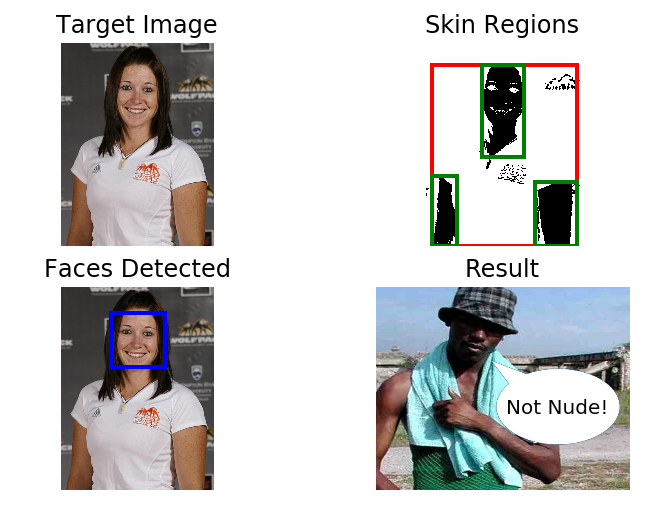

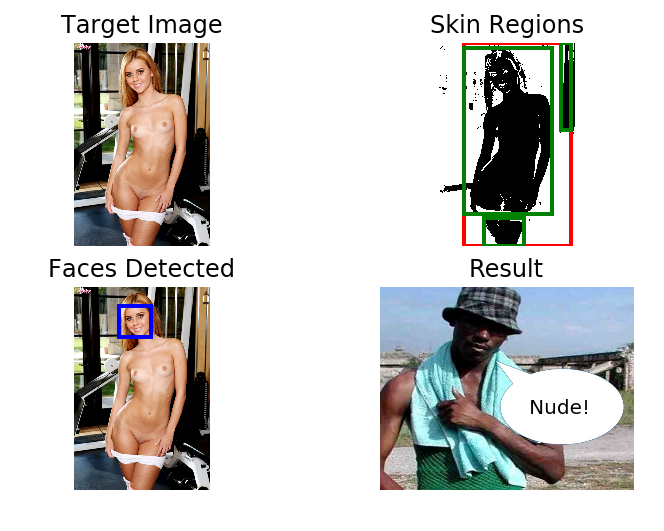

In [26]:
predict_image("5150614150_67ca18893c.jpg",clf)
predict_image("07(7).jpg",clf)

BIBLIOGRAFIA

BASÍLIO, Jorge Alberto Marcial; TORRES, Gualberto Aguilar; PÉREZ, Gabriel Sánchez; MEDINA, L. Karina Toscano; MEANA, Hector M. Pérez. Explicit image detection using YCbCr space color model as skin detection. 5th WSEAS international conference on Computer engineering and applications, Puerto Morelos, México, 2011, pp. 123-128.

KARAVARSAMISA, Sotiris; NTARMOS, Nikos; BLEKAS, Konstantinos; PITASA, Ioannis. Detecting pornographic images by localizing skin ROIs. International Journal of Digital Crime and Forensics, 5(1), pp. 39-53, 2013

KOVAC, J; PEER, P; SOLINA, F. Human skin colour clustering for face detection, Proceeding of EUROCON 2003, Slovenia, Ljubljana, 2003, pp. 144-148.

VIOLA, P., JONES, M. Robust Real-Time Face Detection, International Journal of Computer Vision 57(2), pp. 137-154, 2004

MEDINA, Matías Ré; PALLADINO, Patrício. Pornographic images jacking algorithm, 2013 Disponível em: <https://github.com/alcuadrado/pija>. Acesso em: nov. 2017.
